In [1]:
from neuprint import Client
from neuprint import NeuronCriteria as NC
from neuprint import fetch_neurons
from neuprint import fetch_adjacencies
from neuprint.utils import connection_table_to_matrix
import bokeh.palettes
from bokeh.plotting import figure, show, output_notebook
output_notebook()
import hvplot.pandas
import holoviews as hv
import numpy as np
import pandas as pd
import ants
import nibabel as nib
import os
import pickle
import scipy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import networkx as nx
from fa2 import ForceAtlas2
from nxviz import CircosPlot
import nxviz as nv
import tqdm
import time
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import bigbadbrain as bbb
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.colors as mcolors
import brainsss
import cv2

Loading BokehJS ...

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [ ]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"
#os.listdir(cluster_dir)

['peaks_in_FDA.npy',
 '20221122_temporal_filters.npy',
 '20221122_clusters_exploded.npy',
 '20230203_superthresh_corrs.npy',
 '20221128_indiv_temporal_filters',
 'superclusters.npy',
 '20230420_SC_temporal_filters_v2.npy',
 '20221128_sv_to_sc.npy',
 '20221210_3d_hist_one_cluster_test.npy',
 '20230328_bout_triggered.npy',
 '20221127_unique_glm_indiv_FDA.npy',
 'superclusters_more.npy',
 '20221122_behavior_fwd.npy',
 '20221130_pca_clsuters_in_luke_OG.npy',
 '20230203_superthresh_slopes.npy',
 '20230421_R_triggered_fly087.npy',
 'filters_for_50_superclusters.npy',
 '20230306_L_triggered_all.npy',
 '20221127_singles_glm_indiv_FDA.npy',
 '20221127_temporal_filters_pooled.npy',
 '20230222_SC_temporal_filters_accel.npy',
 '20230306_turn_autocorr.npy',
 '20230421_SC_temporal_filters.npy',
 '20221127_indiv_filters_in_FDA',
 '20221210_3d_hists.npy',
 '20221122_full_supercluster_2d_beh_hists.npy',
 'filters_for_500_superclusters.npy',
 '20230405_confusion_matrix_R.npy',
 'images',
 '20221122_temp

In [ ]:
file = os.path.join(cluster_dir, 'superclusters_more.npy')
superclusters = np.load(file)

file = os.path.join(cluster_dir, 'peaks_in_FDA.npy')
peaks_in_FDA = np.load(file)

file = os.path.join(cluster_dir, 'filters_in_FDA.npy')
filters_in_FDA = np.load(file)

In [ ]:
filters_in_FDA.shape, superclusters.shape

((314, 146, 91, 2000), (314, 146, 91, 499))

In [ ]:
1

In [ ]:
#with 249 there will be clusters 1-250 inclusive (len=250). cluster 140 is background
superclusters_250 = superclusters[:,:,:,249]
# right brain gets +250 to cluster ID so now 500 clusters
superclusters_250[157:,:,:] += 250

In [ ]:
plt.imshow(filters_in_FDA[:,:,50,250].T)

In [ ]:
plt.imshow(superclusters[:,:,50,48].T)

In [ ]:
### lets get average filter for each cluster
#total_clusters = 250#498
#supercluster_ids = np.unique(superclusters[:,:,:,total_clusters])

supercluster_filters = []
for cluster in tqdm.tqdm(range(501)):
    ind = np.where(superclusters_250[:,:,:]==cluster)
    supercluster_filters.append(np.mean(filters_in_FDA[ind[0],ind[1],ind[2],:],axis=0))

In [ ]:
supercluster_filters = np.asarray(supercluster_filters)
supercluster_filters.shape

In [37]:
save_file = os.path.join(cluster_dir, "20221122_temporal_filters")
np.save(save_file, supercluster_filters)

In [16]:
# save_file = os.path.join(cluster_dir, "filters_for_500_superclusters")
# np.save(save_file, supercluster_filters)

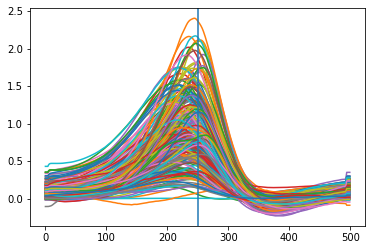

In [17]:
for i in supercluster_ids:
    plt.plot(supercluster_filters[i][0:500])
plt.axvline(250)

In [21]:
### lets get peak time for each supercluster
supercluster_peaks = []
for cluster in range(501):
    supercluster_peaks.append(np.argmax(supercluster_filters[cluster][1000:1500]))

In [22]:
### color brain by peak time
temporal_map = np.zeros((314, 146, 91))
for cluster in range(501):
    ind = np.where(superclusters_250[:,:,:]==cluster)
    temporal_map[ind[0],ind[1],ind[2]] = supercluster_peaks[cluster]

In [12]:
start_c = 265 ###
end_c = 200 ######## most used
middle_c = 250 ###

# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1 = plt.cm.Blues_r(np.linspace(0., 1, middle_c-end_c))
colors2 = plt.cm.Reds(np.linspace(0, 1, start_c-middle_c))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

In [13]:
atlas_clean = brainsss.load_roi_atlas()
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas_clean)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas_clean)

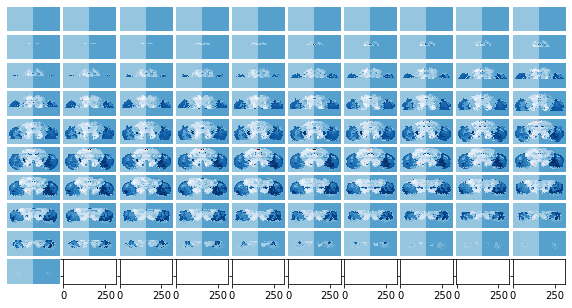

In [17]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(10, 10), axes_pad=.05)
for i in range(91):
    cax = grid[i].imshow(temporal_map[:,:,i].T,cmap=mymap,vmin=end_c,vmax=start_c);
    grid[i].axis('off')
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [20]:
norm = matplotlib.colors.Normalize(vmin=end_c, vmax=start_c)

In [16]:
temporal_map.shape

(314, 146, 91)

In [26]:
tiff_data = mymap(norm(temporal_map))
tiff_data = np.moveaxis(tiff_data,2,0)
tiff_data = np.moveaxis(tiff_data,1,2)

tiff_data.shape

(91, 146, 314, 4)

In [32]:
tiff_data_list = []
for i in range(91):
    tiff_data_list.append(tiff_data[i,...])

In [35]:
tiff_data_list[0].shape

(146, 314, 4)

In [36]:
save_file = os.path.join(cluster_dir, "images", "20221116_fwd")
imageio.mimwrite(save_file,tiff_data_list[0])

ValueError: Could not find a format to write the specified file in mode 'I'

In [28]:
s = 
os.mkdir(s)

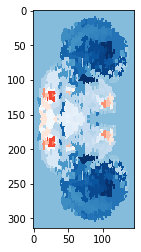

In [23]:
plt.imshow(mymap(norm(temporal_map))[:,:,50,:])

In [ ]:
#imageio.mimwrite('myimgs.tiff',imgs)
#(Nimg, y, x, 3) for RGB color

In [15]:
import imageio

In [18]:
def plot_grouped_roi_image(rois,plot=True):
    roi_data = []
    roi_contours = []

    left_edges = []
    right_edges = []
    bottom_edges = []
    top_edges = []

    for roi in rois:
        ####################
        ### Get roi mask ###
        ####################

        mask = np.zeros(atlas_clean.shape)
        mask[np.where(atlas_clean == roi)] = 1

        mask_eroded = binary_erosion(mask, structure=np.ones((2,2,2)))
        mask_dilated = binary_dilation(mask_eroded, iterations=2)

        # temporal
        masked_roi = mask_dilated*temporal_map #CORR
        masked_roi_flat = np.max(masked_roi,axis=2)
        roi_data.append(masked_roi_flat)
        
        #PCA
#         masked_roi = mask_dilated*pca_map
#         maxs = np.max(masked_roi,axis=2)
#         mins = np.min(masked_roi,axis=2)
#         maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
#         masked_roi_flat = maxs
#         roi_data.append(masked_roi_flat)
    
        #######################
        ### Get roi contour ###
        #######################
        
        _, mask_binary = cv2.threshold(np.max(mask_dilated,axis=-1).astype('uint8'), 0, 1, cv2.THRESH_BINARY) 
        contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#cv2.RETR_TREE

        canvas = np.ones(atlas_clean[:,:,0].shape)
        out = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
        out = np.abs(out-1) #flip 0/1
        roi_contour = np.repeat(out[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white
        roi_contours.append(roi_contour)

        # for plotting
        left_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][0])
        right_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][-1])
        top_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][0])
        bottom_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][-1])
        
    # get extreme edges from all rois used
    left_edge = np.min(left_edges) - 1
    right_edge = np.max(right_edges) + 1
    top_edge = np.min(top_edges) - 1
    bottom_edge = np.max(bottom_edges) + 1

    ############
    ### PLOT ###
    ############
    
    roi_datas = np.max(np.asarray(roi_data),axis=0)
    data_map = np.swapaxes(roi_datas[top_edge:bottom_edge,left_edge:right_edge],0,1)
    
    #PCA
#     roi_data = np.asarray(roi_data)
#     maxs = np.max(roi_data,axis=0)
#     mins = np.min(roi_data,axis=0)
#     maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
#     data_map = np.swapaxes(maxs[top_edge:bottom_edge,left_edge:right_edge],0,1)

    if plot:
        plt.figure(figsize=(10,10))
        plt.imshow(data_map)

    contours_to_export = []
    for i in range(len(roi_contours)):
        single_contour = np.swapaxes(roi_contours[i][top_edge:bottom_edge,left_edge:right_edge],0,1)
        contours_to_export.append(single_contour)
        if plot:
            plt.imshow(single_contour)
        
    return data_map, contours_to_export

def place_on_canvas(input_canvas, to_plot, is_contour=False, is_midline=True, x_shift=0, y_shift=0):
    full_y_mid = int(input_canvas.shape[0]/2)
    full_x_mid = int(input_canvas.shape[1]/2)

    y_mid = int(to_plot.shape[0]/2)
    x_mid = int(to_plot.shape[1]/2)

    height = to_plot.shape[0]
    width = to_plot.shape[1]

    left = full_x_mid-x_mid
    right = left + width

    top = full_y_mid-y_mid
    bottom = top + height

    if is_contour:
        ys = np.where(to_plot[:,:,0]>0)[0] + full_y_mid - y_mid + y_shift
        xs = np.where(to_plot[:,:,0]>0)[1] + full_x_mid - x_mid + x_shift
        input_canvas[ys,xs]=1
    else:
        #input_canvas[top+y_shift:bottom+y_shift,left+x_shift:right+x_shift,:3] = to_plot
        input_canvas[top+y_shift:bottom+y_shift,left+x_shift:right+x_shift] = to_plot #pca
    return input_canvas

def place_on_canvas_wrapper(canvas, data_map, contours, y_shift, x_shift):
    canvas = place_on_canvas(canvas, to_plot=data_map, y_shift=y_shift, x_shift=x_shift)
    for i in range(len(contours)):
        canvas = place_on_canvas(canvas, to_plot=contours[i], is_contour=True, y_shift=y_shift, x_shift=x_shift)
    return canvas

def wraper_wraper(canvas, roi_ids, y_shift, x_shift):
    data_map, contours = plot_grouped_roi_image(roi_ids, plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    return canvas

In [19]:
##################
### ROI GROUPS ###
##################

FB_group = {
26: 'FB',
4: 'NO',
5: 'BU_R',
54: 'BU_L',
8: 'LAL_R',
56: 'LAL_L',
31: 'PVLP_R',
76: 'PVLP_L'}

ventromedial_r_group = {
13: 'VES_R',  
40: 'EPA_R',
35: 'GOR_R',
11: 'AMMC_R'}

ventromedial_l_group = {
60: 'VES_L', 
85: 'EPA_L',
80: 'GOR_L',
58: 'AMMC_L'}

PB = {6: 'PB'}
EB = {23: 'EB'}

anterior_group = {
50: 'PRW',
9: 'SAD',
49: 'GNG',
30: 'AVLP_R',
75: 'AVLP_L',
24: 'AL_R',
70: 'AL_L',
64: 'MB_PED_L',
65: 'MB_VL_L',
66: 'MB_ML_L',
81: 'MB_CA_L',
17: 'MB_PED_R',
18: 'MB_VL_R',
19: 'MB_ML_R',
36: 'MB_CA_R',
32: 'IVLP_R',
77: 'IVLP_L',
10: 'CAN_R',
20: 'FLA_R',
57: 'CAN_L',
67: 'FLA_L'}

big_r_group = {
27: 'SLP_R',
29: 'SMP_R',
33: 'PLP_R',
7: 'LH_R',
38: 'IPS_R',
37: 'SPS_R',
16: 'CRE_R',
39: 'SCL_R',
12: 'ICL_R',
15: 'ATL_R',
14: 'IB_R',
28: 'SIP_R'}
    
big_l_group = {
72: 'SLP_L',   
74: 'SMP_L',
78: 'PLP_L',
55: 'LH_L',
83: 'IPS_L',
82: 'SPS_L',
63: 'CRE_L',
84: 'SCL_L',  
59: 'ICL_L',
62: 'ATL_L',
61: 'IB_L',
73: 'SIP_L'}

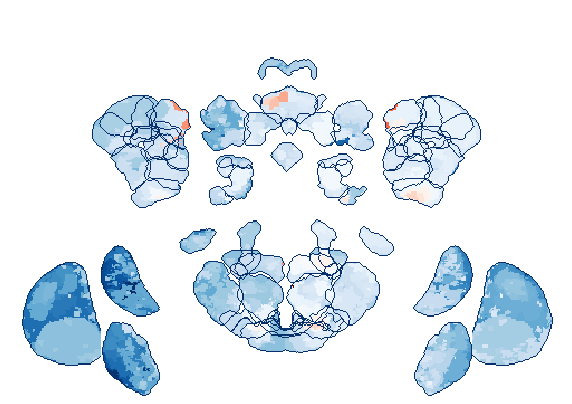

In [23]:
#input_canvas = np.zeros((500,500,3))
input_canvas = np.zeros((500,500)) #pca


x_shift=0; y_shift=0
data_map, contours = plot_grouped_roi_image(FB_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=0; y_shift=-45
data_map, contours = plot_grouped_roi_image(PB.keys(), plot=False)
canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=0; y_shift=35
data_map, contours = plot_grouped_roi_image({23: 'EB'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

##########
### MB ###
##########

# x_shift=60; y_shift=-50
# data_map, contours = plot_grouped_roi_image(MB_left_group.keys(), plot=False)
# canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
# x_shift=-60; y_shift=-50
# data_map, contours = plot_grouped_roi_image(MB_right_group.keys(), plot=False)
# canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

#################
### BIG GROUP ###
#################

x_shift=-130; y_shift=30
data_map, contours = plot_grouped_roi_image(big_r_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=130; y_shift=30
data_map, contours = plot_grouped_roi_image(big_l_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

##############
### VISUAL ###
##############

x_shift=-200; y_shift=175
data_map, contours = plot_grouped_roi_image({25: 'MED_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=200; y_shift=175
data_map, contours = plot_grouped_roi_image({71: 'MED_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=-140; y_shift=40+175
data_map, contours = plot_grouped_roi_image({3: 'LO_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=140; y_shift=40+175
data_map, contours = plot_grouped_roi_image({53: 'LO_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=-140; y_shift=-30+175
data_map, contours = plot_grouped_roi_image({22: 'LP_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=140; y_shift=-30+175
data_map, contours = plot_grouped_roi_image({69: 'LP_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

canvas = wraper_wraper(canvas, ventromedial_r_group.keys(), y_shift=55, x_shift=-50)
canvas = wraper_wraper(canvas, ventromedial_l_group.keys(), y_shift=55, x_shift=50)

canvas = wraper_wraper(canvas, anterior_group.keys(), y_shift=150, x_shift=0)

canvas = wraper_wraper(canvas, {34: 'AOTU_R'}.keys(), y_shift=-50+175-15, x_shift=-80)
canvas = wraper_wraper(canvas, {79: 'AOTU_L'}.keys(), y_shift=-50+175-15, x_shift=80)
    
canvas[np.where(canvas==0)] = np.nan

plt.figure(figsize=(10,10))
plt.imshow(canvas[150:,:],cmap=mymap,vmin=end_c,vmax=start_c)
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

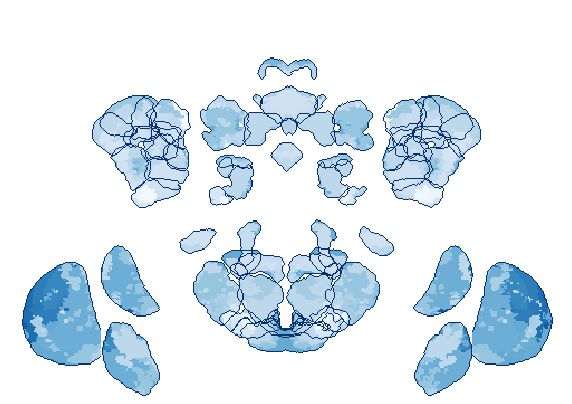

In [29]:
canvas[np.where(canvas==0)] = np.nan

plt.figure(figsize=(10,10))
plt.imshow(canvas[150:,:],cmap=mymap,vmin=end_c,vmax=start_c)
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}_wlk')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [ ]:
end_c